In [28]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

In [66]:
vueltas = pd.read_csv("../dataset_todos_pilotos/vueltas_spain_final.csv")
#vueltas.drop(['Piloto'], axis = 1, inplace = True)

vueltas_train = vueltas[vueltas['anyo'].isin([2018, 2019, 2020])]
vueltas_validation = vueltas[vueltas['anyo'].isin([2021])]
vueltas_test = vueltas[vueltas['anyo'] == 2022]

vueltas_test = vueltas_test[vueltas_test['Piloto'] == "bottas"]

vueltas_train = vueltas_train.drop(['anyo'], axis=1)
vueltas_validation = vueltas_validation.drop(['anyo'], axis=1)
vueltas_test = vueltas_test.drop(['anyo'], axis=1)
#vueltas_test = vueltas_test.drop(['Stint'], axis=1)
vueltas_train.drop(['Piloto'], axis = 1, inplace = True)
vueltas_validation.drop(['Piloto'], axis = 1, inplace = True)
vueltas_test.drop(['Piloto'], axis = 1, inplace = True)



vueltas_train = vueltas_train.astype(float)
vueltas_validation = vueltas_validation.astype(float)
vueltas_test = vueltas_test.astype(float)

In [67]:
scaler = MinMaxScaler()
scaler.fit(vueltas_train)
vueltas_train_scaler = scaler.transform(vueltas_train)
vueltas_test_scaler = scaler.transform(vueltas_test)
vueltas_validation_scaler = scaler.transform(vueltas_validation)

In [68]:
trainX = []
trainY = []
testX = []
testY = []
validationX = []
validationY = []
loopback = 10 # Esto es el numero de muestras que usara en el pasado 
future = 1 # Esto es el numero de hechos futuros que usará como salida a las 10 muestras del pasado

for i in range (loopback, len(vueltas_train_scaler) -future +1):
    trainX.append(vueltas_train_scaler[i-loopback:i, 0:vueltas_train.shape[1]])
    trainY.append(vueltas_train_scaler[i + future - 1:i + future, 5])
    
for i in range (loopback, len(vueltas_test_scaler) -future +1):
    testX.append(vueltas_test_scaler[i-loopback:i, 0:vueltas_test.shape[1]])
    testY.append(vueltas_test_scaler[i + future - 1:i + future,5])
    
for i in range (loopback, len(vueltas_validation_scaler) -future +1):
    validationX.append(vueltas_validation_scaler[i-loopback:i, 0:vueltas_validation.shape[1]])
    validationY.append(vueltas_validation_scaler[i + future - 1:i + future,5])


In [69]:
trainX, trainY, testX, testY, validationX, validationY = np.array(trainX), np.array(trainY), np.array(testX), np.array(testY), np.array(validationX), np.array(validationY)

In [70]:
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer="adam", loss= "mse") ##Cambiar esto para la siguiente reunion (positivo 1, negativo 0)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 256)           283648    
                                                                 
 dropout_6 (Dropout)         (None, 10, 256)           0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 480,897
Trainable params: 480,897
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
48/48 [==============================] - 4s 42ms/step - loss: 0.0345
Epoch 2/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0169
Epoch 3/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0130
Epoch 4/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0110
Epoch 5/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0104
Epoch 6/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0092
Epoch 7/12
48/48 [==============================] - 2s 39ms/step - loss: 0.0089
Epoch 8/12
48/48 [==============================] - 2s 39ms/step - loss: 0.0087
Epoch 9/12
48/48 [==============================] - 2s 39ms/step - loss: 0.0080
Epoch 10/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0083
Epoch 11/12
48/48 [==============================] - 2s 39ms/step - loss: 0.0083
Epoch 12/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0073


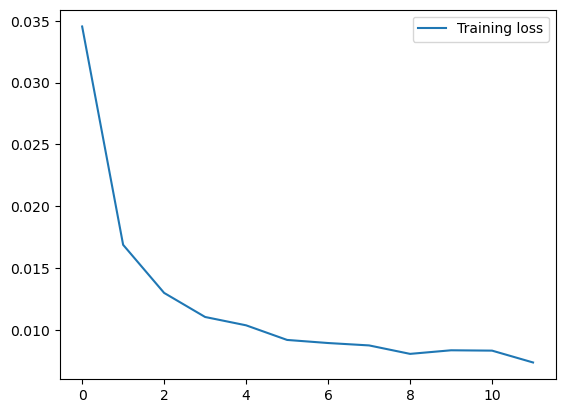

In [71]:
history = model.fit(trainX, trainY, epochs=12, batch_size=64, validation_split=0.0, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.legend()

In [72]:
clases = np.unique(trainY[:,0]) #Cuidado de donde sacamos las clases, deberiamos sacarlas de train, 
#pero si en 2021 hubo una parada mas por lo que sea, falla lo de abajo, lo he hecho con validationY pero
# y si hace una menos en validation?
clases

#Por ejemplo en arabia saudi solo hubo 3 paradas, por lo cual es 0, 0,5 y 1. Si en validation hay 5,
#ya no coinciden, es decir, no las va a predecir, que es lo que hablamos la semana anterior


array([0.        , 0.33333333, 0.66666667, 1.        ])

In [73]:
f = lambda x: np.argwhere(x == clases)
f = np.vectorize(f)
y_real = f(validationY[:,0])

In [74]:
#AQUI ES CON LOS DATOS DE VALIDADACION
predictions = model.predict(validationX)

32/32 [==============================] - 1s 9ms/step


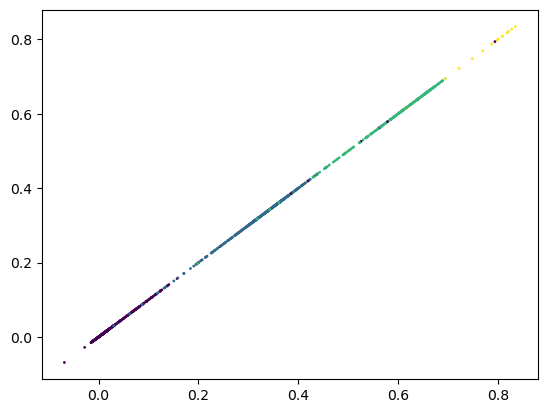

In [75]:
plt.scatter(predictions[:,0], predictions[:,0], s=1, c=y_real+1)

In [76]:
y_real_train = f(trainY[:,0])

In [77]:
predictions_test = model.predict(testX)

2/2 [==============================] - 0s 8ms/step


In [78]:
y_real_test =  f(testY[:,0])

In [79]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(predictions, y_real, test_size=0.3, stratify=y_real)

In [80]:
from sklearn.linear_model import LogisticRegression
rl = LogisticRegression(random_state=0, penalty=None).fit(predictions, y_real) # Esto es de validacion

In [81]:
pred_test_2 = rl.predict(predictions_test)

In [82]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm = confusion_matrix(y_real_test, pred_test_2)
metricas = classification_report(y_real_test, pred_test_2)

In [83]:
print(cm)
print(metricas)

[[ 3  0  0]
 [ 2 18  0]
 [ 0  1 30]]
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.95      0.90      0.92        20
           2       1.00      0.97      0.98        31

    accuracy                           0.94        54
   macro avg       0.85      0.96      0.89        54
weighted avg       0.96      0.94      0.95        54



In [65]:
nombre_archivo = "ejecuciones/ejecuciones_val_2021/saudi_arabia.txt"

# Abrir el archivo en modo de escritura
with open(nombre_archivo, "w") as archivo:
    print("Matriz de confusión:", file=archivo)
    print(clases, file=archivo)
    print(cm, file=archivo)
    print("Métricas:", file=archivo)
    print(metricas, file=archivo)